In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import cython

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
matplotlib.rcParams.update({'font.size': 12})

In [3]:
# параметры установки
d = 45e-3 # калибр
S = np.pi*d**2/4 # площадь
W_0 = 0.005 # объем каморы
l_d = 4.5 # длина ствола
m_elem = 0.52 # масса МЭ
p_f = 172e6 # давление форсирования

In [4]:
k_r0 = 9.87e8 # предэскп. множитель 
Q_t = 13.4e6 # энергия образования 1 кг продуктов реакций 
E_ign = 0 # энергия воспламенителя
# E_ign = 45e3 # энергия воспламенителя
E_a = 60e3 # энергия активации

In [5]:
v_p0 = 0 # начальная скорость
x_p0 = 0 # начальная координата
p_a = 1e5 # атмосфэрное давление

In [6]:
p_0 = 34.5e6 # начальное давление
T_0 = 300 # начальная температура
R_u = 8.31446262 # универсальная газовая постоянная
hi_O2_and_H2_0 = 1/8 # начальное соотношение мольных долей

In [7]:
mu_H2 = 2e-3 # молярная масса водорода
mu_O2 = 32e-3 # молярная масса кислорода
mu_H2O = 18e-3 # молярная масса воды

In [8]:
%load_ext cython

In [50]:
%%cython
import numpy as np
cimport numpy as np
from cython cimport floating

# Начальный вектор молярных концентраций
def C_initial(p_0, W_0, T_0, hi):
    cdef double R_u=8.31446262
    
    return np.array([(p_0 * W_0/(R_u * T_0))/(hi + 1.0)/W_0,
                    (p_0 * W_0/(R_u * T_0))/(hi + 1.0)/W_0 * hi,
                    0])

# Показатель адиабаты элемента
def foo_k(double T, str gas_name):
    if gas_name == 'H2':
        return 1 + sum(np.array([0.3975, 0.4814e-4, -1.073e-7, 4.6863e-11, -8.5361e-15, 5.6934e-19] * np.array([1, T, T**2, T**3, T**4, T*5])))
    elif gas_name == 'O2':
        return 1 + sum(np.array([0.4697, -2.9819e-4, 2.0320e-7, -7.1938e-11, 12.311e-15, -8.0736e-19] * np.array([1, T, T**2, T**3, T**4, T*5])))             
    elif gas_name == 'H2O':
        return 1 + sum(np.array([0.3834, -1.8579e-4, 0.6266e-7, -1.0528e-11, 0.93554e-15, -0.38512e-19] * np.array([1, T, T**2, T**3, T**4, T*5])))

# Показатель адиабаты смеси
def k_smesi(double T, np.ndarray[double, ndim=1] C, double W):
    return 1 + C[0]*W*((C[0]*W/(foo_k(T,'H2')-1) + C[1]*W/(foo_k(T,'O2')-1) + C[2]*W/(foo_k(T,'H2O')-1))**(-1)) + C[1]*W*((C[0]*W/(foo_k(T,'H2')-1) + C[1]*W/(foo_k(T,'O2')-1) + C[2]*W/(foo_k(T,'H2O')-1))**(-1)) + C[2]*W*((C[0]*W/(foo_k(T,'H2')-1) + C[1]*W/(foo_k(T,'O2')-1) + C[2]*W/(foo_k(T,'H2O')-1))**(-1))

# Скорость реакции (закон Арениуса)
def foo_k_r(double T):
    cdef double k_r0=9.87e8, E_a=60e3, R_u=8.31446262
    return k_r0 * np.e**(-E_a/(R_u*T))

# Функция альфа из предиктора корректора
def foo_alpha(np.ndarray[double, ndim=1] arr):
    cdef int i
    res_arr = np.array([])
    for i in range(len(arr)):
        if abs(arr[i]) >= 1e-5:
            res_arr = np.append(res_arr, (1-(1 - np.e**(-arr[i]))/arr[i])/(1 - np.e**(-arr[i])))
        else:
            res_arr = np.append(res_arr, 0.5)
        return res_arr

# Метод предиктор корректор    
def alpha_QSS(np.ndarray[double, ndim=1] C_n, double T, double dt, double W_n, double W_n_1):
    cdef int i
    cdef np.ndarray[double, ndim=1] P_n, D_n, C_n_kr, D_n_kr

    P_n = np.array([0, 
                    0, 
                    foo_k_r(T)*C_n[0]*C_n[1]**(1.0/2.0)])

    D_n = np.array([foo_k_r(T)*C_n[1]**(1.0/2.0), 
                    1.0/2.0*foo_k_r(T)*C_n[0]*C_n[1]**(-1.0/2.0),
                    0])
    
    # Предиктор вектора
    C_n_kr = W_n/W_n_1 * (C_n + (dt *(P_n-C_n*D_n))/(1.0+foo_alpha(D_n*dt)*D_n*dt))
    
    if C_n_kr[0] >= 1e-1 and C_n_kr[1] >= 1e-1:
        D_n_kr = (np.array([foo_k_r(T)*C_n_kr[1]**(1/2), 
                            1.0/2*foo_k_r(T)*C_n_kr[0]*C_n_kr[1]**(-1/2),
                            0]) + D_n)/2.0
        P_n_kr = foo_alpha(D_n_kr*dt)*np.array([0, 
                                         0, 
                                         foo_k_r(T)*C_n_kr[0]*C_n_kr[1]**(1/2)]) + (1.0-foo_alpha(D_n_kr*dt))*P_n   
    else:
        D_n_kr = np.array([0.0,0.0,0.0])
        P_n_kr = np.array([0.0,0.0,0.0])
        
    # Возврат корректора    
    return W_n/W_n_1 * (C_n + (dt *(P_n_kr-C_n*D_n_kr))/(1.0+foo_alpha(D_n_kr*dt)*D_n_kr*dt))
    
# def time_step(double p_m, double p_last, value_of_p_gradient, dt, schetchik, np.ndarray[double, ndim=1] p_arr):
#     try:
#         if ((p_m-p_last)/10**6 >= value_of_p_gradient):
#             return dt/10
#         elif ((p_m-p_last)/10**6 < value_of_p_gradient) and (p_m-p_last > 0) and (schetchik > 10000):
#             return dt
#         elif (round(p_m,3)-round(p_last,3) <= 0) and (round(p_m,3)-round(p_arr[-1],3) <= 0) and (schetchik>10000):
#             return 1e-6
#     except:
#         return dt

# Шаг по времени
def time_step(double p_m, double p_last,double value_of_p_gradient,double dt,int schetchik, int count_dt,int flag_dt):
    if schetchik == 1:
        dt = 1e-7
        count_dt = 0
    elif ((p_m-p_last)/10**6 >= value_of_p_gradient) and (flag_dt == 0) and (count_dt > 10):
        dt = 1e-8
        flag_dt = 1
        count_dt = 0
    elif ((p_m-p_last)/10**6 >= value_of_p_gradient) and (flag_dt == 1) and (count_dt > 10):
        dt = 1e-9
        flag_dt = 2
        count_dt = 0
    elif ((p_m-p_last)/10**6 >= value_of_p_gradient) and (flag_dt == 2) and (count_dt > 10):
        dt = 1e-10
        flag_dt = 3
        count_dt = 0
    elif ((p_m-p_last)/10**6 >= value_of_p_gradient) and (flag_dt == 3) and (count_dt > 10):
        dt = 1e-11
        flag_dt = 4
        count_dt = 0
    elif ((p_m-p_last)/10**6 >= value_of_p_gradient) and (flag_dt == 4) and (count_dt > 10):
        dt = 1e-12
        flag_dt = 5
        count_dt = 0
    elif ((p_m-p_last)/10**6 >= value_of_p_gradient) and (flag_dt == 5) and (count_dt > 10):
        dt = 1e-13
        flag_dt = 6
        count_dt = 0
    elif ((p_m-p_last)/10**6 >= value_of_p_gradient) and (flag_dt == 6) and (count_dt > 10):
        dt = 1e-14
        flag_dt = 7
        count_dt = 0
    elif ((p_m-p_last)/10**6 >= value_of_p_gradient) and (flag_dt == 7) and (count_dt > 10):
        dt = 1e-15
        flag_dt = 8
        count_dt = 0
    elif ((p_m-p_last)/10**6 >= value_of_p_gradient) and (flag_dt >= 8) and (count_dt > 10):
        dt = 1e-16
        count_dt = 0
    elif (round(p_m/10**6,3)-round(p_last/10**6,3) <= 0) and (flag_dt > 0) and (count_dt > 10):
        dt = 1e-6
    return dt, flag_dt, count_dt

# Термодинамическая модель
def termodynamic_system(double p_0, double W_0, double T_0, double hi_second_to_first):
    cdef np.ndarray[double, ndim=1] C_n_1, C_n, tau_arr, v_p_arr, p_m_arr, p_b_arr, x_p_arr, T_arr
    cdef double v_p0=0, x_p0=0, l_d=4.5, mu_H2O=18e-3, mu_H2=2e-3, mu_O2=32e-3, m_elem=0.52, Q_t=13.4e6, E_ign=0, R_u=8.31446262, p_f=172e6, p_a=1e5, S=np.pi*(45e-3)**2/4, dv_p=0
    cdef int schetchik, falg_fors, flag_dt, count_dt
    # tau, W_n_1, v_p, x_p, T, p_m, value_of_p_gradient, 
    
    tau = 0
    
    C_n_1 = C_initial(p_0, W_0, T_0, hi_second_to_first)

    k_smesi_T_0 = k_smesi(T_0, C_n_1, W_0)
    W_n_1 = W_0 
    v_p = v_p0 
    x_p = x_p0 
    T = T_0 
    p_m = p_0 

    tau_arr = np.array([])
    v_p_arr = np.array([])
    p_m_arr = np.array([])
    p_b_arr = np.array([])
    x_p_arr = np.array([])
    T_arr = np.array([])

    schetchik = 0
    p_last = p_0
    value_of_p_gradient = 1e-2
    flag_dt = 0
    flag_fors = 0
    count_dt = 0
    
    dt = 1e-7

    while (x_p <= l_d) and (tau<=7e-3):
        schetchik += 1
        
        dt, flag_dt, count_dt = time_step(p_m, p_last, value_of_p_gradient, dt, schetchik, count_dt, flag_dt)
            
        count_dt += 1

        p_last = p_m
        
        tau += dt

        C_n = C_n_1

        W_n = W_n_1

        M_p = mu_H2O * C_n[2] * W_n

        phi = (1+(C_n[0] * W_n * mu_H2 + C_n[1] * W_n * mu_O2 + C_n[2] * W_n * mu_H2O)/(3*m_elem))
        
        p_m = (k_smesi(T, C_n, W_n)-1)/W_n * ((p_0*W_0)/(k_smesi_T_0-1) + Q_t*M_p - E_ign - phi/2*m_elem*v_p**2) # среднебаллистическое давление
        
        T = p_m*W_n/(R_u*(C_n[0] * W_n + C_n[1] * W_n + C_n[2] * W_n))

        if p_m <= p_f and falg_fors == 0:
            dv_p = 0
        elif p_m <= p_f and falg_fors == 1:
            dv_p = (p_m - p_a)*S/(phi*m_elem) * dt
        elif  p_m > p_f:
            falg_fors = 1
            dv_p = (p_m - p_a)*S/(phi*m_elem) * dt

        v_p += dv_p

        dx_p = v_p * dt

        x_p += dx_p

        W_n_1 = W_0 + x_p*S  # Заснарядный объем на n+1 шаге

        W_n = W_0 + (x_p-dx_p)*S # Заснарядный объем на n шаге

        C_n_1 = alpha_QSS(C_n, T, dt, W_n, W_n_1)
        
#         p_b = p_m * (1+(m_H2 + m_O2 + m_H2O)/(2*m_elem))/(1+(m_H2 + m_O2 + m_H2O)/(3*m_elem))
               
        if schetchik % 1_000 == 0:
            tau_arr = np.append(tau_arr, tau)
            x_p_arr = np.append(x_p_arr, x_p)
            v_p_arr = np.append(v_p_arr, v_p)
            T_arr = np.append(T_arr, T)
            p_m_arr = np.append(p_m_arr, p_m)
            
#             p_b_arr = np.append(p_b_arr, p_m)
#             print(tau, x_p, v_p, p_m/10**6, (p_m - p_last)/10**6, C_n_1, dt)
#         if p_m >= 265e6:
#             print(tau, x_p, v_p, p_m/10**6, (round(p_m/10**6,3)-round(p_last/10**6,3)), C_n_1, dt)

    tau_arr = np.append(tau_arr, tau)
    x_p_arr = np.append(x_p_arr, x_p)
    v_p_arr = np.append(v_p_arr, v_p)
    T_arr = np.append(T_arr, T)
    p_m_arr = np.append(p_m_arr, p_m)
#     p_b_arr = np.append(p_b_arr, p_m)

    return {'tau':tau_arr, 'x_p':x_p_arr,
           'v_p':v_p_arr, 'T':T_arr, 'p_m':p_m_arr}

In [51]:
%%time
res = termodynamic_system(p_0, W_0, T_0, 1/8)

Wall time: 8.07 s


In [52]:
df = pd.DataFrame.from_dict(res)

In [53]:
df.head()

,tau,x_p,v_p,T,p_m
0,0.0001,0.0,0.0,301.504608,3.467077e+07
1,0.0002,0.0,0.0,303.213952,3.486475e+07
2,0.0003,0.0,0.0,305.186718,3.508859e+07
3,0.0004,0.0,0.0,307.513554,3.535254e+07
4,0.0005,0.0,0.0,310.340353,3.567314e+07


In [54]:
df.shape

(93, 5)

In [55]:
df.p_m.max()/10**6,df.loc[df.shape[0]-1].v_p

(205.06040527686267, 1614.6878577353104)

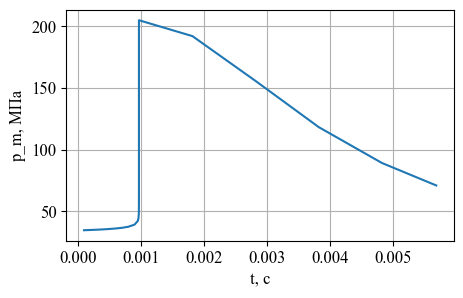

In [56]:
plt.figure(figsize=(5,3))
plt.plot(df.tau, df.p_m/10**6)
plt.xlabel('t, с')
plt.ylabel('p_m, МПа')
plt.grid()

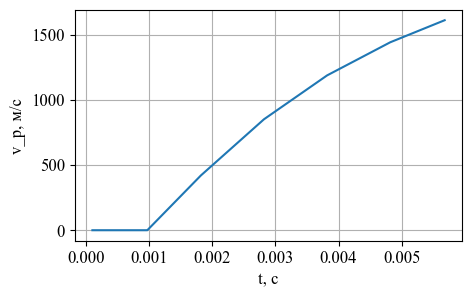

In [57]:
plt.figure(figsize=(5,3))
plt.plot(df.tau, df.v_p)
plt.xlabel('t, с')
plt.ylabel('v_p, м/с')
plt.grid()

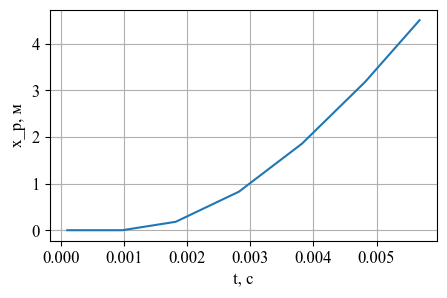

In [58]:
plt.figure(figsize=(5,3))
plt.plot(df.tau, df.x_p)
plt.xlabel('t, с')
plt.ylabel('x_p, м')
plt.grid()

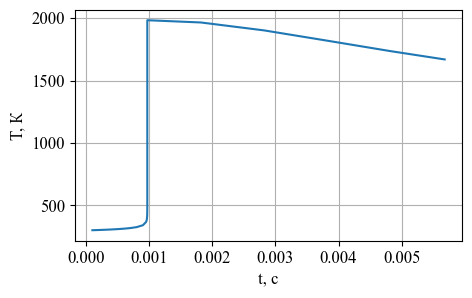

In [59]:
plt.figure(figsize=(5,3))
plt.plot(df.tau, df['T'])
plt.xlabel('t, с')
plt.ylabel('T, К')
plt.grid()